In [73]:
import duckdb
from pathlib import Path

duckdb_path = "data/sakila.duckdb"
Path(duckdb_path).unlink(missing_ok=True)

with duckdb.connect(duckdb_path) as conn, open("sql/load_sakila.sql") as ingest_script:
    conn.sql(ingest_script.read())

    description = conn.sql("DESC;").df()


In [74]:
description.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
2,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False
3,sakila,main,city,"[city_id, city, country_id, last_update]","[BIGINT, VARCHAR, BIGINT, TIMESTAMP]",False
4,sakila,main,country,"[country_id, country, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


### Read all tables into dataframes

In [96]:
dfs = {}

with duckdb.connect(duckdb_path) as conn:
    for name in description["name"]:
        if name[0] != '_':
            dfs[name] = conn.sql(f"FROM {name};").df()

dfs.keys()

dict_keys(['actor', 'address', 'category', 'city', 'country', 'customer', 'customer_list', 'film', 'film_actor', 'film_category', 'film_list', 'film_text', 'inventory', 'language', 'payment', 'rental', 'sales_by_film_category', 'sales_by_store', 'staff', 'staff_list', 'store'])

### register dataframes to duckdb

In [76]:
table_names = ["category", "film_category", "language", "actor", "film_actor", "film", 
               "inventory", "inventory", "payment", "customer", "rental"]
for table_name in table_names:
    duckdb.register(table_name, dfs[table_name])



## Task 1 - EDA in python

In [77]:
# a) Movies longer than 3 hours

duckdb.sql(
    """--sql
    SELECT title, length as length_in_minutes
    FROM film
    WHERE length > 180
    ORDER BY length DESC;
"""
).df().head()

,title,length_in_minutes
0,WORST BANGER,185
1,CHICAGO NORTH,185
2,CONTROL ANTHEM,185
3,DARN FORRESTER,185
4,SWEET BROTHERHOOD,185


In [78]:
# b) Movies with the word "love" in the title
# Solution using 'ILIKE' (to include small and capital letters) 
duckdb.sql(
    """--sql
    SELECT title, rating, length, description
    FROM film
    WHERE title ILIKE '% love %' 
    OR title ILIKE  'love %'
    OR title ILIKE '% love';
"""
).df()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [79]:
# Solution usring RegEx
# (?i) to include small and capital letters
duckdb.sql(
    """--sql
Select title, rating, length, description
           from film
           where regexp_matches(title, '(?i)\\bLOVE\\b');
"""
).df()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


In [80]:
# c) Length statistics

duckdb.sql(
    """--sql
    SELECT
    MIN(length) AS Shortest_movie_length,
    ROUND(AVG(length)) AS Average_movie_length,
    MEDIAN(length) AS Median_movie_lenth,
    MAX(length) AS Longest_movie_length
    FROM film;
"""
).df()

,Shortest_movie_length,Average_movie_length,Median_movie_lenth,Longest_movie_length
0,46,115.0,114.0,185


In [81]:
# d) Most expensive movies to rent per day

duckdb.sql(
    """--sql
    SELECT title, 
    rental_rate,
    rental_duration,
    (rental_rate/rental_duration) AS rental_cost_per_day
    FROM film
    ORDER BY rental_cost_per_day DESC;
"""
).df().head(10)

,title,rental_rate,rental_duration,rental_cost_per_day
0,PATHS CONTROL,4.99,3,1.663333
1,BACKLASH UNDEFEATED,4.99,3,1.663333
2,BEHAVIOR RUNAWAY,4.99,3,1.663333
3,VIRTUAL SPOILERS,4.99,3,1.663333
4,TEEN APOLLO,4.99,3,1.663333
5,TELEGRAPH VOYAGE,4.99,3,1.663333
6,BILKO ANONYMOUS,4.99,3,1.663333
7,HEARTBREAKERS BRIGHT,4.99,3,1.663333
8,CLERKS ANGELS,4.99,3,1.663333
9,TIES HUNGER,4.99,3,1.663333


In [82]:
# Check if the result above is reasonable
duckdb.sql(
    """--sql
    SELECT
    rental_rate, rental_duration
    FROM film
    ORDER BY rental_rate DESC;
"""
).df().head()

,rental_rate,rental_duration
0,4.99,6
1,4.99,3
2,4.99,4
3,4.99,6
4,4.99,7


In [83]:
# e) Top 10 actors whos played in most movies
# I count the number of 'film_id' to get number of films,
# and then I join table 'actor' with 'film_actor' by actor_id,
# and table 'film_actor' with 'film' by film_id.

duckdb.sql(
    """--sql
    SELECT
        a.first_name || ' ' || a.last_name as actor,
        COUNT(f.film_id) as number_films
    FROM actor a
    LEFT JOIN film_actor fa ON fa.actor_id = a.actor_id 
    LEFT JOIN film f ON f.film_id = fa.film_id
    GROUP BY actor
    ORDER BY number_films DESC
    LIMIT 10;
"""
).df()

,actor,number_films
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,VAL BOLGER,35
8,HENRY BERRY,35
9,GROUCHO DUNST,35


### f) My own questions to explore the sakila database

In [84]:
# 1. Which is the top 5 most rented film categorys among customers?
# Caluculate percentage number of rentals using a subquery
# JOIN tables to get the number of rented films
duckdb.sql(
    """--sql
    SELECT
        c.name AS category,
        ROUND(((CAST(COUNT(r.rental_id) AS DOUBLE) * 100.0)/ (SELECT COUNT(rental_id) FROM rental)),2) AS percentage_rental
    FROM category c
    INNER JOIN film_category fc ON fc.category_id = c.category_id 
    INNER JOIN film f ON f.film_id = fc.film_id
    INNER JOIN inventory i ON i.film_id = f.film_id
    INNER JOIN rental r ON r.inventory_id = i.inventory_id
    GROUP BY category
    ORDER BY percentage_rental DESC;
"""
).df().head(5)

,category,percentage_rental
0,Sports,7.35
1,Animation,7.27
2,Action,6.93
3,Sci-Fi,6.86
4,Family,6.83


In [85]:
# 2. 'Susan Davis' has played in most movies,
# but in what top 3 genre has she done most movies?
duckdb.sql(
    """--sql
    SELECT
        a.first_name || ' ' || a.last_name as actor,
        c.name as top_category,
        COUNT(fa.film_id) AS films_per_category
    FROM actor a
    INNER JOIN film_actor fa ON fa.actor_id = a.actor_id 
    INNER JOIN film_category fc ON fa.film_id = fc.film_id
    INNER JOIN category c ON c.category_id = fc.category_id 
    WHERE a.first_name ILIKE 'Susan' AND a.last_name ILIKE 'Davis'
    GROUP BY actor, top_category
    ORDER BY films_per_category DESC
    LIMIT 3;
"""
).df()

,actor,top_category,films_per_category
0,SUSAN DAVIS,Children,6
1,SUSAN DAVIS,Action,5
2,SUSAN DAVIS,Sci-Fi,4


In [86]:
duckdb.sql("FROM language").df()

,language_id,name,last_update
0,1,English,2021-03-06 15:51:48
1,2,Italian,2021-03-06 15:51:48
2,3,Japanese,2021-03-06 15:51:48
3,4,Mandarin,2021-03-06 15:51:48
4,5,French,2021-03-06 15:51:48
5,6,German,2021-03-06 15:51:48


In [87]:
# 3. Which movies has language 'Mandarin'?
duckdb.sql(
    """--sql
    SELECT
        l.name as language,
        f.title
    FROM language l
    INNER JOIN film f ON l.language_id = f.language_id
    WHERE l.name = 'Mandarin';
"""
).df()

,language,title


In [88]:
# 4. Are there any movies with another language than 'English'?
duckdb.sql(
    """--sql
    SELECT
        l.name as language,
        COUNT(f.film_id) AS number_of_films
    FROM language l
    INNER JOIN film f ON l.language_id = f.language_id
    GROUP BY language
    ORDER BY number_of_films DESC;
"""
).df()

,language,number_of_films
0,English,1000


In [95]:
# 5. At what time does most people rent movie?
duckdb.sql("""--sql
    SELECT
        EXTRACT(HOUR FROM rental_date) AS rental_hour,
        CASE
        WHEN EXTRACT(HOUR FROM rental_date) BETWEEN 6 AND 11 THEN 'Morning (06-11)'
        WHEN EXTRACT(HOUR FROM rental_date) BETWEEN 12 AND 16 THEN 'Daytime (12-16)'
        WHEN EXTRACT(HOUR FROM rental_date) BETWEEN 17 AND 21 THEN 'Evening (17-21)'
        ELSE 'Nighttime (22-05)'
        END AS time_of_day,
           
        COUNT(rental_id) AS total_rentals
    FROM rental
    GROUP BY time_of_day, rental_hour
    ORDER BY total_rentals
""").df()

,rental_hour,time_of_day,total_rentals
0,22,Nighttime (22-05),610
1,2,Nighttime (22-05),630
2,12,Daytime (12-16),632
3,17,Evening (17-21),634
4,23,Nighttime (22-05),642
5,13,Daytime (12-16),645
6,6,Morning (06-11),647
7,5,Nighttime (22-05),648
8,1,Nighttime (22-05),649
9,9,Morning (06-11),652


## Task 2 - graphs

In [90]:
# Check what we'll need
duckdb.sql("FROM payment").df().head()
duckdb.sql("FROM customer").df().head()
duckdb.sql("FROM rental").df().head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2021-03-06 15:53:41
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2021-03-06 15:53:41
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2021-03-06 15:53:41
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2021-03-06 15:53:41
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2021-03-06 15:53:41


In [91]:
# a) Top 5 customers by total spent
# Create a dataframe with the top 5 customer with highest total spent
# Using SUM(p.amount) to calculate total spent per customer
Top_five_df = duckdb.sql(
    """--sql
    SELECT
        c.first_name || ' ' || c.last_name AS customer,
        SUM(p.amount) AS total_spent_USD
    FROM rental r
    INNER JOIN payment p ON p.rental_id = r.rental_id
    INNER JOIN customer c ON c.customer_id = r.customer_id
    GROUP BY customer
    ORDER BY total_spent_USD DESC;
"""
).df()

Top_five_df.head(5)  # To only get the top 5

,customer,total_spent_USD
0,KARL SEAL,221.55
1,ELEANOR HUNT,216.54
2,CLARA SHAW,195.58
3,MARION SNYDER,194.61
4,RHONDA KENNEDY,194.61


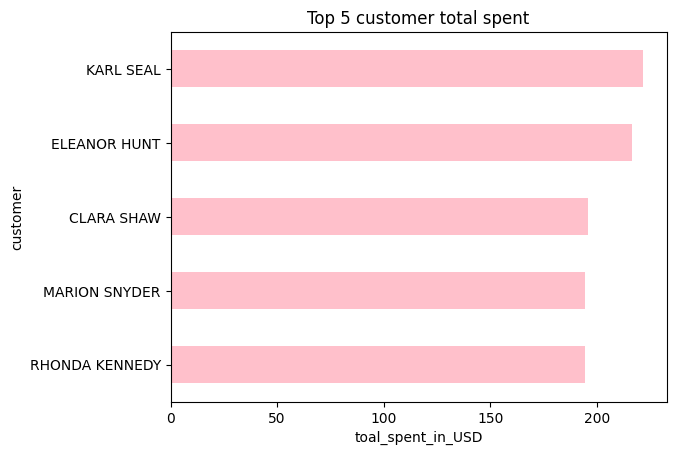

In [92]:
# Check that it works
Top_five_df

# Create the bar chart
ax = Top_five_df.head(5).plot(
    kind="barh",
    x="customer",
    y="total_spent_USD",
    title="Top 5 customer total spent",
    xlabel="toal_spent_in_USD",
    legend = False,
    color = "pink"
)

ax.invert_yaxis()

In [93]:
# b) Most profitable film category
Category_revenue = duckdb.sql(
    """--sql
    SELECT
        c.name AS category,
        ROUND(SUM(p.amount)) as total_revenue
    FROM category c
    INNER JOIN film_category fc ON fc.category_id = c.category_id
    INNER JOIN film f ON f.film_id = fc.film_id
    INNER JOIN inventory i ON i.film_id = f.film_id
    INNER JOIN rental r ON r.inventory_id = i.inventory_id
    INNER JOIN payment p ON p.rental_id = r.rental_id
    GROUP BY category
    ORDER BY total_revenue DESC;
"""
).df()

Category_revenue

,category,total_revenue
0,Sports,5314.0
1,Sci-Fi,4757.0
2,Animation,4656.0
3,Drama,4587.0
4,Comedy,4384.0
5,Action,4376.0
6,New,4352.0
7,Games,4281.0
8,Foreign,4271.0
9,Family,4226.0


<Axes: title={'center': 'Category total revenue'}, xlabel='Category', ylabel='Total revenue USD'>

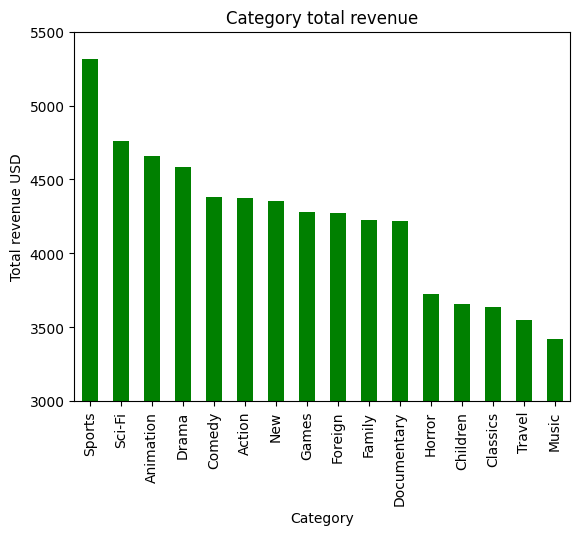

In [94]:
# Plot bar chart 
Category_revenue.plot(
    kind="bar",
    x="category",
    y="total_revenue",
    xlabel="Category",
    ylabel="Total revenue USD",
    title="Category total revenue",
    legend=False,
    ylim=[3000,5500],
    color = "green"
)


## Task 3 (Bonus) - BI report